In [1]:
import sys, os, time
sys.path.append('../..')
import pyzx as zx
from benchmarking import benchmark
sys.path.append('/Users/calum/Developer/pyzx-heuristics-master')
import pyzx_heur as zx_heuristics

To use the benchmarking class, we first create our benchmark object. 

If a previous object has been saved (using ``b.save('dirpath')``), we can load this directly from the directory.

In [2]:
# b = benchmark()
b = benchmark(dirpath='b2')

We can then load the set of circuits which we want to benchmark. 

If we have a set of already optimised circuits via a different routine, we can also load these. 

Here we load a set of optimised circuits using the routine from [Nam, Ross, Su, Childs, Maslov - Automated optimization of large quantum circuits with continuous parameters](https://www.nature.com/articles/s41534-018-0072-4).

In [3]:
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking', 'Fast', 'before'), group_name='fast')
b.load_circuits(dirname=os.path.join('..', '..', 'circuits', 'benchmarking', 'Fast', 'nrscm'), group_name='fast', simp_strategy='NRSCM')
b.show_attributes()

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_opt']
Loaded functions:  ['full_reduce', 'cFlow_2']
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast']


Original NRSCM cFlow_2 full_reduce
fast        Y     Y       Y           Y

We can then define the optimisation functions which we want to benchmark. These should take a circuit as input and output the optimised circuit.

In [4]:
def basic_optimise(c):
    c1 = zx.optimize.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.optimize.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2 # As this optimisation algorithm is targetted at reducting H-gates, we use the circuit with the smaller 2-qubit gate count here, either using SWAP rules or not.
    return c1

def full_reduce(c):
    g = c.to_graph()
    zx.simplify.full_reduce(g,quiet=True)
    c2 = zx.extract_circuit(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def flow_optimise(c):
    g = c.to_graph()
    zx.simplify.teleport_reduce(g, store=True)
    g.place_tracked_phases(allow_jumping=True)
    zx.simplify.to_graph_like(g, assert_bound_connections=False)
    zx.simplify.flow_2Q_simp(g, cFlow=True, rewrites=['id_fuse','lcomp','pivot'], max_lc_unfusions=2, max_p_unfusions=2)
    g.place_tracked_phases()
    c2 = zx.extract_simple(g,up_to_perm=False).to_basic_gates()
    return basic_optimise(c2)

def zx_heur_nu(circ):
    c = zx_heuristics.Circuit.from_quipper(circ.to_quipper())
    g = c.to_graph()
    g = zx_heuristics.simplify.teleport_reduce(g)
    g.track_phases = False
    zx_heuristics.simplify.greedy_simp_neighbors(g)
    c2 = zx_heuristics.extract_circuit(g, up_to_perm=False).to_basic_gates()
    return basic_optimise(zx.Circuit.from_quipper(c2.to_quipper()))

These functions can then be added to the benchmark object. If desired they can also be deleted using ``b.del_simplification_funcs(['func'])``.

They can either be run immediately on a group of circuits (default is all), or run afterwards.

The optimised circuits can optionally be verified to equal the original circuit (by using full_reduce on the original + adjoint).

In [5]:
b.add_simplification_func(func=full_reduce, name='full_reduce', groups_to_run=['fast'], verify=True, rerun=False)

b.add_simplification_func(func=flow_optimise, name='cFlow_4', groups_to_run=None)
# b.run(funcs_to_run=['cFlow_4'], groups_to_run=['fast'], verify=True, rerun=False)

b.show_attributes()

100%|██████████| 31/31 [00:00<00:00, 178114.28it/s]

Circuit attributes:  ['Qubits', 'Gates', '2Q Count', 'T Count', 't_opt']
Loaded functions:  ['full_reduce', 'cFlow_2', 'cFlow_4']
Loaded routines:  ['NRSCM']
Loaded circuit groups:  ['fast']


Original NRSCM cFlow_2 cFlow_4 full_reduce
fast        Y     Y       Y       -           Y

In [6]:
b.add_simplification_func(func=flow_optimise, name='cFlow_2_w', groups_to_run=['fast'], rerun=True)

Processing cFlow_2_w on qft_4                                         : 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]


You can then view the results in a dataframe.

In [7]:
df = b.df(groups=['fast'], routines=['all'], funcs=['all'], atts=['Qubits','2Q Count','T Count', 't_opt'])

You can also generate graphs based on optimisations of randomly generated circuits.

Processing zx_heur_nu on P_t = 0.15               : 100%|██████████| 11/11 [45:38<00:00, 248.93s/it]


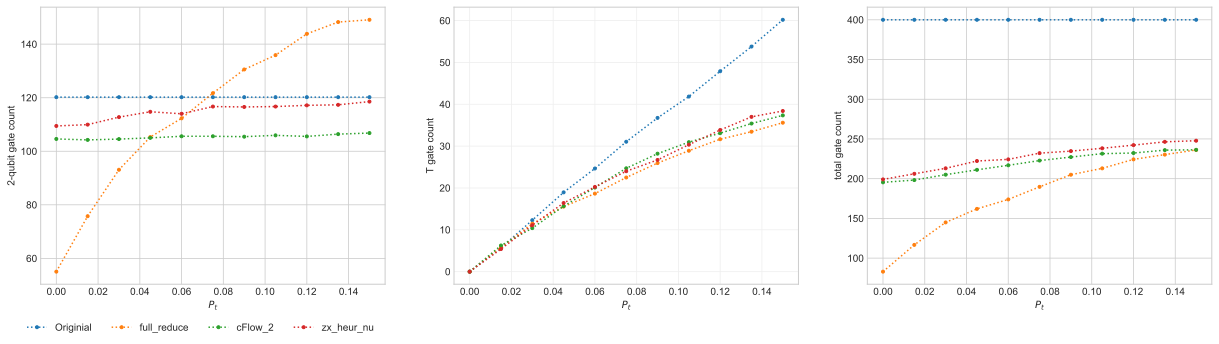

In [12]:
fig = b.Pt_graphs(funcs=['full_reduce', 'cFlow_2', 'zx_heur_nu'], qubits=8, depth=400, cnot_prob=0.3, t_probs=[0.015*i for i in range(11)], ys=['2Q Count', 'T Count', 'Gates'], reps=20, overwrite=False, random_seed=42)

In [9]:
b.save('b2')